In [ ]:
!pip install pyspark
!pip install findspark

In [1]:
import findspark
findspark.init()

from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

spark = SparkSession.builder.appName("Phân tích mô tả").getOrCreate()

25/06/18 02:04:34 WARN Utils: Your hostname, macbook.local resolves to a loopback address: 127.0.0.1; using 192.168.3.49 instead (on interface en0)
25/06/18 02:04:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/18 02:04:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
cwd = os.getcwd()
csv_path = os.path.abspath(os.path.join(cwd, "../data/raw/Course_info.csv"))
print("Resolved CSV path:", csv_path)

Resolved CSV path: /Users/zan/Downloads/udemy-course-purchase-prediction/data/raw/Course_info.csv


In [7]:
# In ra thư mục hiện tại để kiểm tra
print("Current working directory:", os.getcwd())

# Nếu cần: chuyển về thư mục gốc của project (nếu đang mở notebook trong subfolder `notebooks/`)
# os.chdir("/Users/zan/Desktop/udemy-course-purchase-prediction")

# Lấy đường dẫn tuyệt đối đến file CSV
csv_path = "../data/raw/Course_info.csv"
print("CSV path:", csv_path)

# Khởi tạo Spark session
spark = SparkSession.builder.appName("EDA").getOrCreate()

# Đọc dữ liệu
df = spark.read.option("header", True).csv(csv_path, inferSchema=True)
df.show(5)
df.printSchema()

Current working directory: /Users/zan/Downloads/udemy-course-purchase-prediction/notebooks
CSV path: ../data/raw/Course_info.csv
+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+--------------------+----------------+---------+-------------------+-------------+--------+--------------------+---------------+------------------+
|    id|               title|is_paid| price|            headline|num_subscribers|avg_rating|num_reviews|num_comments|num_lectures|content_length_min|      published_time|last_update_date| category|        subcategory|        topic|language|          course_url|instructor_name|    instructor_url|
+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+--------------------+----------------+---------+-------------------+-------------+--------+--------------------+---------------+

In [8]:


# Các cột số cần ép kiểu
numeric_columns = {
    "id": DoubleType(),
    "price": DoubleType(),
    "num_subscribers": DoubleType(),
    "avg_rating": DoubleType(),
    "num_reviews": DoubleType(),
    "num_comments": DoubleType(),
    "num_lectures": DoubleType(),
    "content_length_min": DoubleType(),
    "most_common_price": DoubleType(),
    "result": IntegerType()
}

# Ép kiểu an toàn bằng cách dùng hàm `when` kết hợp `rlike`
for col, dtype in numeric_columns.items():
    if col in df.columns:
        # chỉ cast nếu dữ liệu là dạng số, còn lại thành None
        df = df.withColumn(
            col,
            F.when(F.col(col).rlike(r'^\d+(\.\d+)?$'), F.col(col).cast(dtype)).otherwise(None)
        )

# In lại schema xác nhận
df.printSchema()


root
 |-- id: double (nullable = true)
 |-- title: string (nullable = true)
 |-- is_paid: string (nullable = true)
 |-- price: double (nullable = true)
 |-- headline: string (nullable = true)
 |-- num_subscribers: double (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- num_reviews: double (nullable = true)
 |-- num_comments: double (nullable = true)
 |-- num_lectures: double (nullable = true)
 |-- content_length_min: double (nullable = true)
 |-- published_time: string (nullable = true)
 |-- last_update_date: string (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- language: string (nullable = true)
 |-- course_url: string (nullable = true)
 |-- instructor_name: string (nullable = true)
 |-- instructor_url: string (nullable = true)



In [ ]:
# Lấy danh sách các cột có kiểu số sau khi ép kiểu
numerical_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in ("double", "int", "float", "long") and f.name != 'id']
print("Các cột số:", numerical_cols)

In [9]:
# Hàm tính giá trị mode (giá trị xuất hiện nhiều nhất) của một cột
def compute_mode(df, col):
    mode_row = df.groupBy(col).count().orderBy(F.desc("count")).first()
    return mode_row[col] if mode_row else None

Tính thống kê cho: price


Tính thống kê cho: num_subscribers


Tính thống kê cho: avg_rating


Tính thống kê cho: num_reviews
Tính thống kê cho: num_comments


Tính thống kê cho: num_lectures


Tính thống kê cho: content_length_min
 Đã xuất thống kê mô tả ra: summary_stats.csv
Thống kê mô tả:
               column   count  mean  stddev  min       max  q1  median    q3   iqr  mode
0               price  209692    82     117    0     1,000  20      35   100    80    20
1     num_subscribers  209440 3,094  15,530    0 1,752,364  25     201 1,349 1,324     0
2          avg_rating  209616    10   1,393    0   626,304   4       4     5     1     0
3         num_reviews  209687   244   2,430    0   436,457   3      17    70    67     0
4        num_comments  209715    46     519    0   172,991   1       5    17    16     0
5        num_lectures  209729    37      88    0    24,886  11      21    41    30     0
6  content_length_min  209733   265     461    0    36,899  68     131   281   213     0


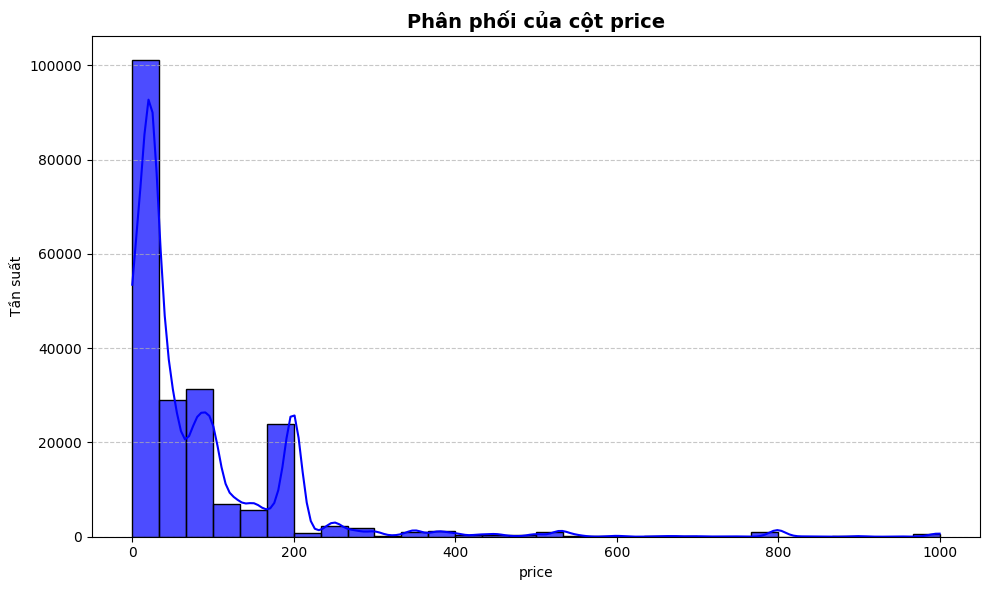

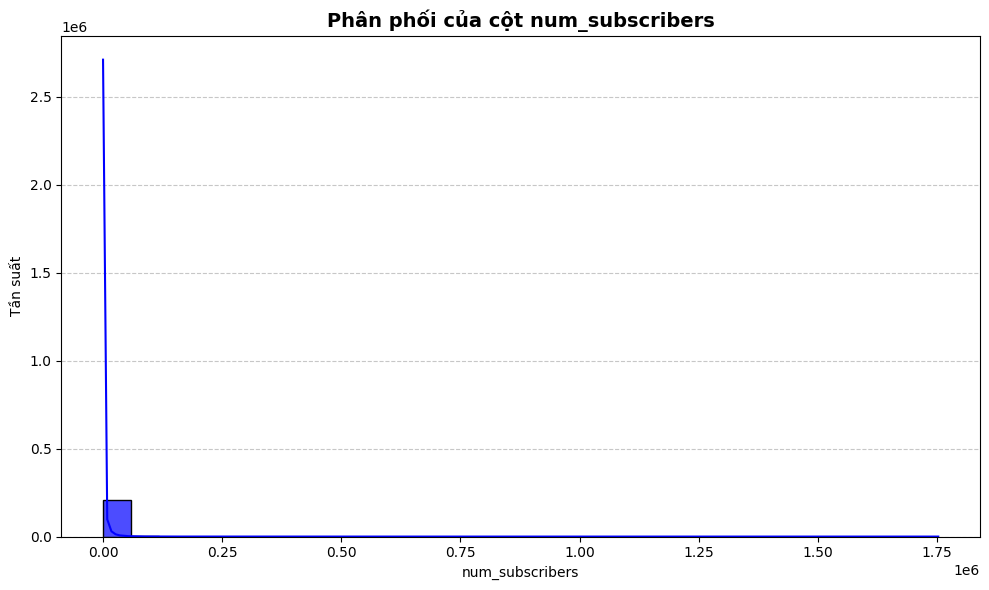

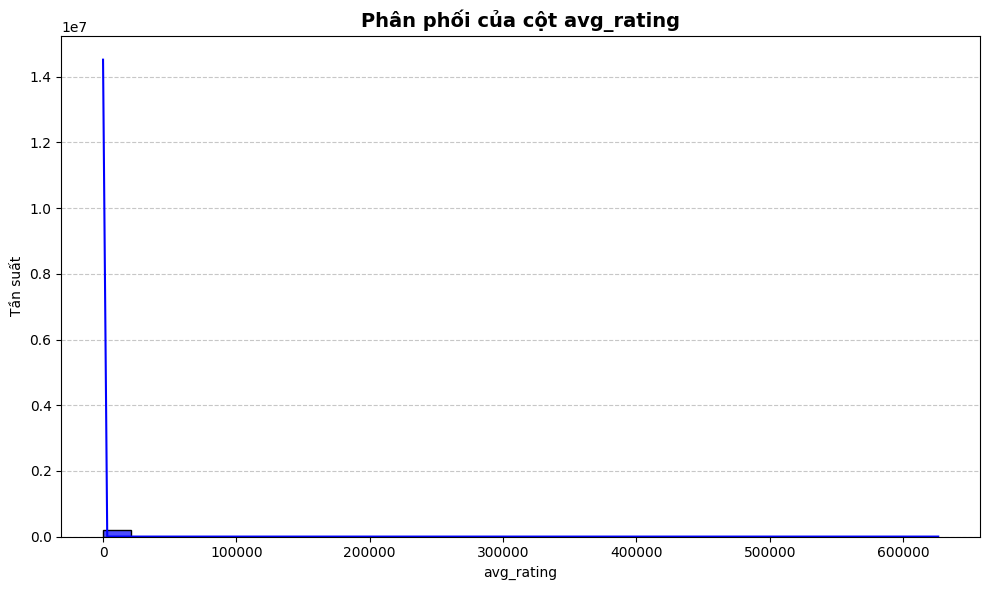

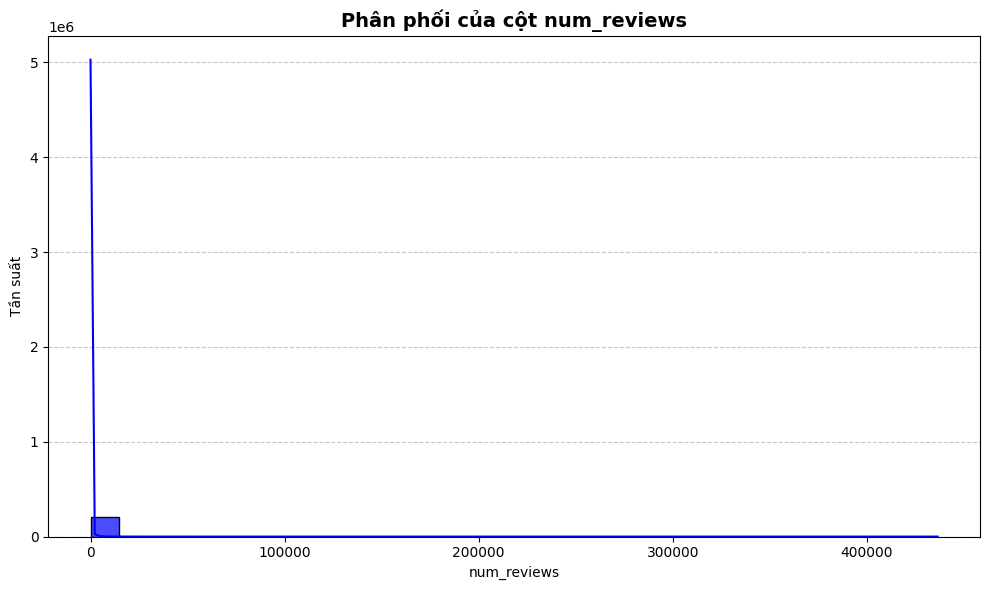

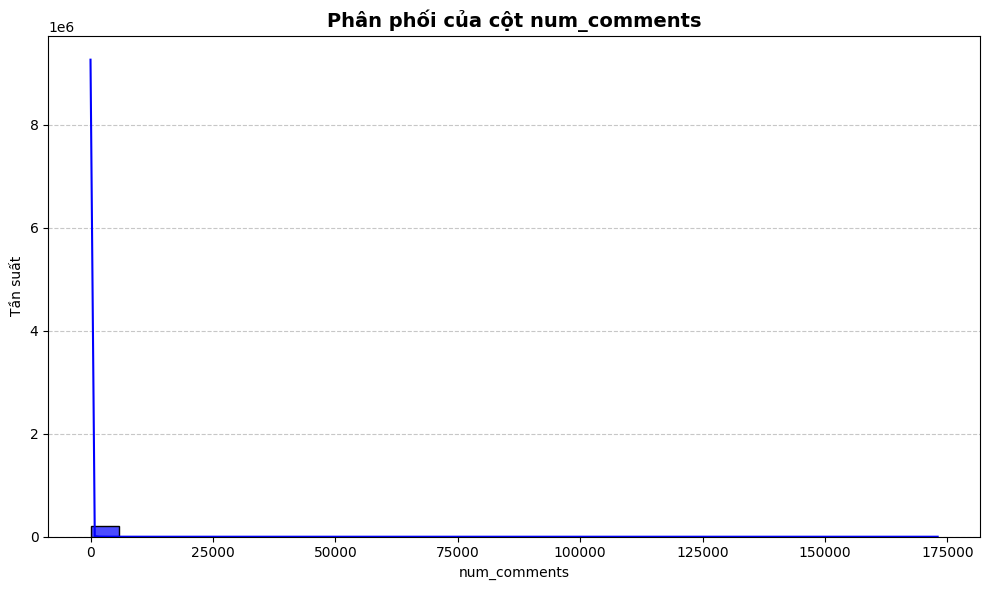

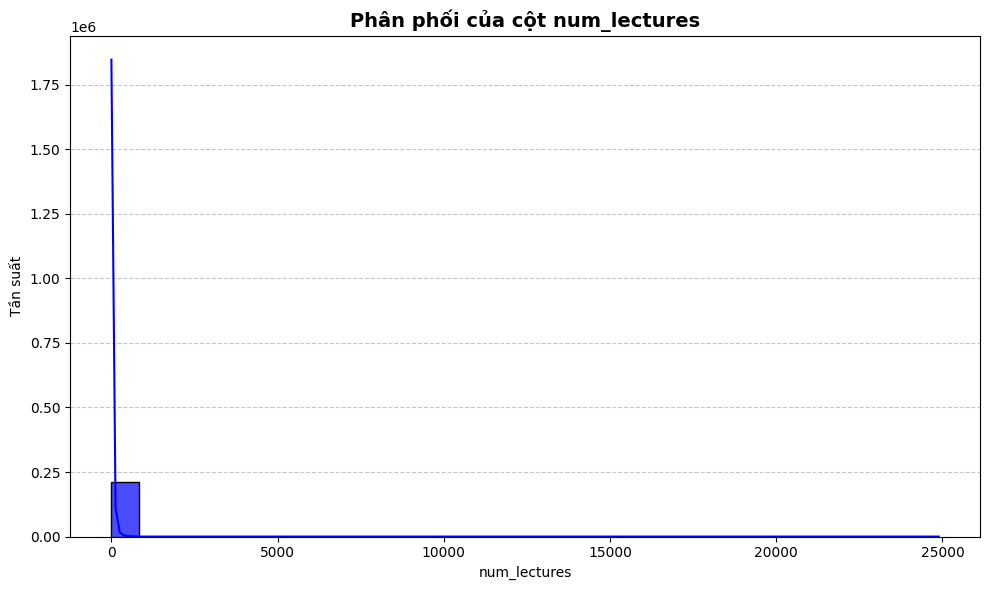

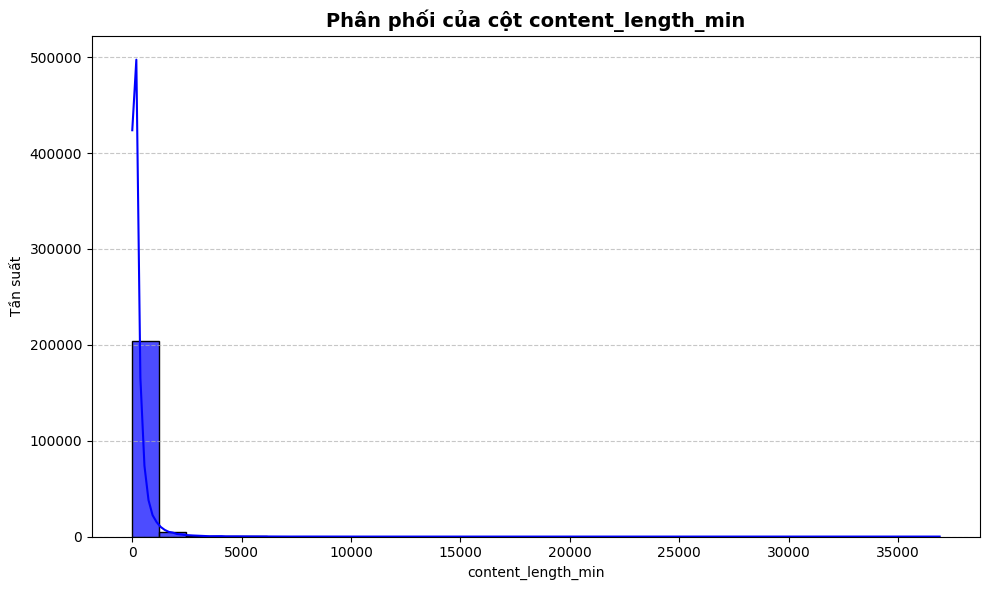

In [13]:
def describe_extended(df, output_path="summary_stats.csv"):
    numerical_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in ("double", "int", "float", "long") and f.name != 'id']
    results = []

    for col in numerical_cols:
        print(f"Tính thống kê cho: {col}")
        approx = df.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = approx if len(approx) == 3 else (None, None, None)
        iqr = q3 - q1 if q3 and q1 else None
        mode = compute_mode(df, col)

        agg = df.agg(
            F.count(col).alias("count"),
            F.mean(col).alias("mean"),
            F.stddev(col).alias("stddev"),
            F.min(col).alias("min"),
            F.max(col).alias("max"),
            F.countDistinct(col).alias("unique")
        ).collect()[0]

        results.append({
            "column": col,
            "count": agg["count"],
            "mean": agg["mean"],
            "stddev": agg["stddev"],
            "min": agg["min"],
            "max": agg["max"],
            "q1": q1,
            "median": median,
            "q3": q3,
            "iqr": iqr,
            "mode": mode
        })

    pd.DataFrame(results).to_csv(output_path, index=False)
    print(f" Đã xuất thống kê mô tả ra: {output_path}")
    
    return numerical_cols  


numerical_cols = describe_extended(df, output_path="summary_stats.csv")
pd.set_option('display.float_format', '{:.0f}'.format)  # Hiển thị số nguyên đầy đủ
summary_df = pd.read_csv("summary_stats.csv")
pd.set_option('display.float_format', '{:,.0f}'.format)  # Hiển thị số đầy đủ
pd.set_option('display.max_columns', None)       # Hiện tất cả các cột
pd.set_option('display.expand_frame_repr', False)  # Không gãy dòng xuống khi quá rộng
pd.set_option('display.width', 1000)             # Tăng giới hạn chiều ngang in ra
print("Thống kê mô tả:")
print(summary_df)

# Vẽ biểu đồ
df_pd = df.select(numerical_cols).toPandas()

# Hàm vẽ phân phối cho một cột
def plot_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column].dropna(), kde=True, bins=30, color="blue", alpha=0.7)
    plt.title(f"Phân phối của cột {column}", fontsize=14, weight="bold")
    plt.xlabel(column)
    plt.ylabel("Tần suất")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

for col in numerical_cols:
    plot_distribution(df_pd, col)

📌 Ma trận tương quan:
                    price  num_subscribers  avg_rating  num_reviews  num_comments  num_lectures  content_length_min
price                1.00             0.02        0.00         0.03          0.03          0.09                0.15
num_subscribers      0.02             1.00        0.08         0.73          0.73          0.18                0.12
avg_rating           0.00             0.08        1.00        -0.00          0.73          0.72                0.00
num_reviews          0.03             0.73       -0.00         1.00          0.65          0.13                0.13
num_comments         0.03             0.73        0.73         0.65          1.00          0.62                0.10
num_lectures         0.09             0.18        0.72         0.13          0.62          1.00                0.43
content_length_min   0.15             0.12        0.00         0.13          0.10          0.43                1.00


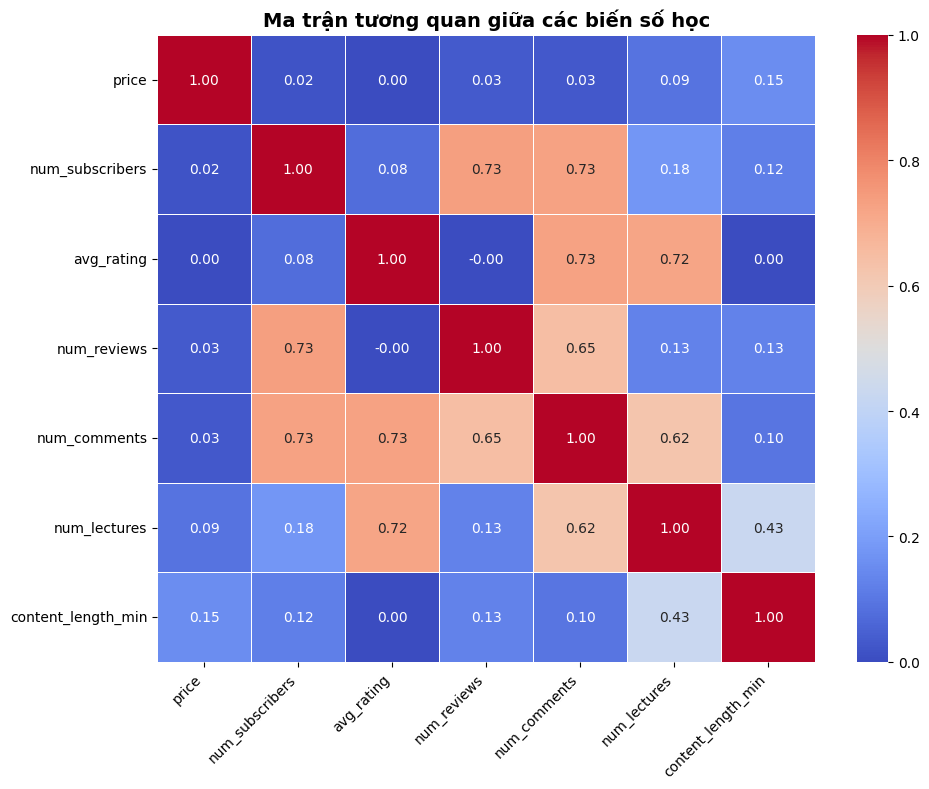

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Chuyển Spark DataFrame sang pandas nếu chưa
df_pd = df.select(*[f.name for f in df.schema.fields if f.dataType.simpleString() in ("double", "int", "float", "long") and f.name != "id"]).toPandas()

# Tính ma trận tương quan Pearson
corr_matrix = df_pd.corr(numeric_only=True)

# Tùy chọn hiển thị số rõ ràng
pd.set_option('display.float_format', '{:.2f}'.format)

# In ma trận tương quan
print("Ma trận tương quan:")
print(corr_matrix)

# Vẽ heatmap tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Ma trận tương quan giữa các biến số học", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

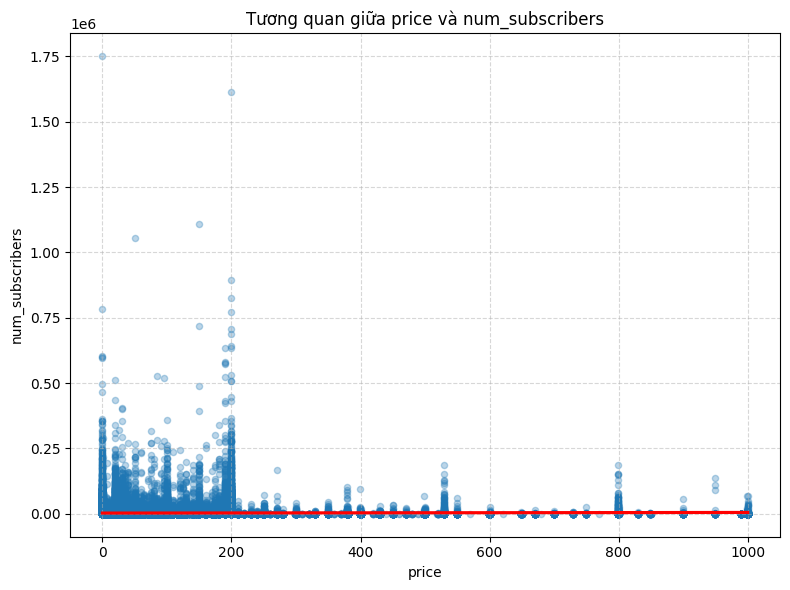

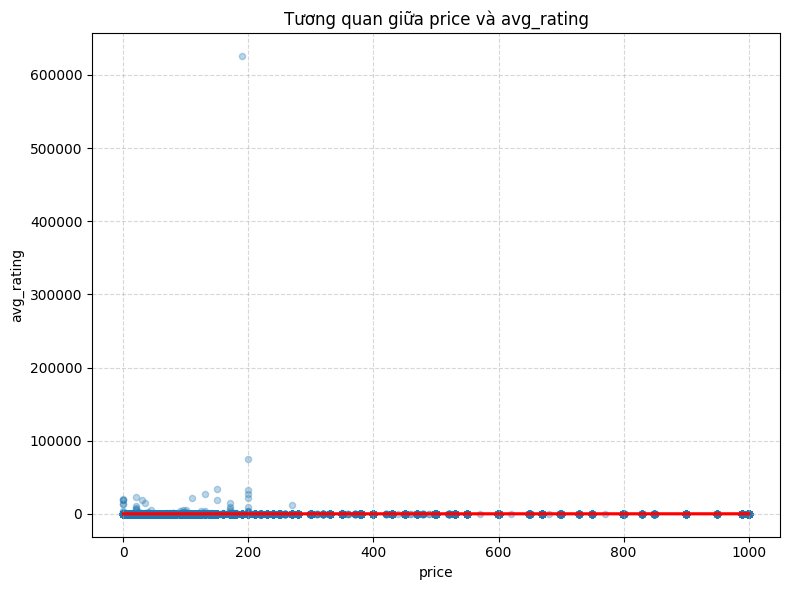

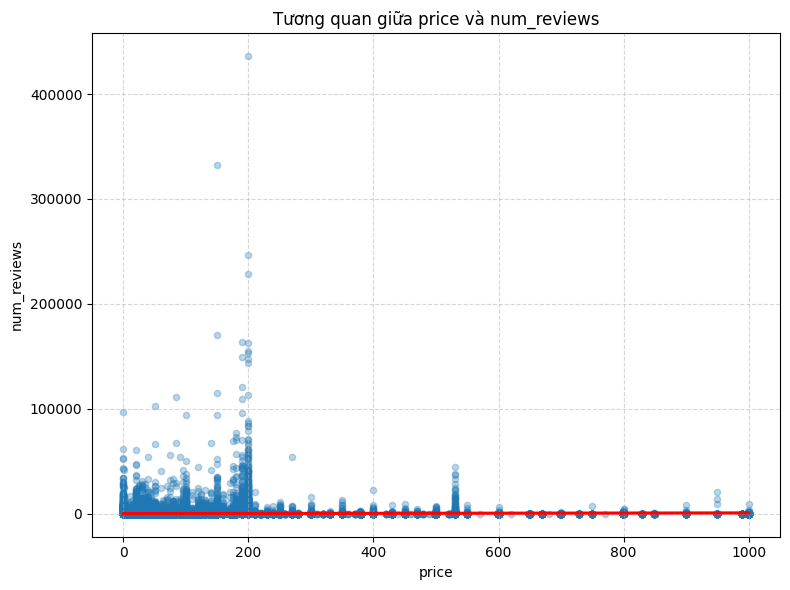

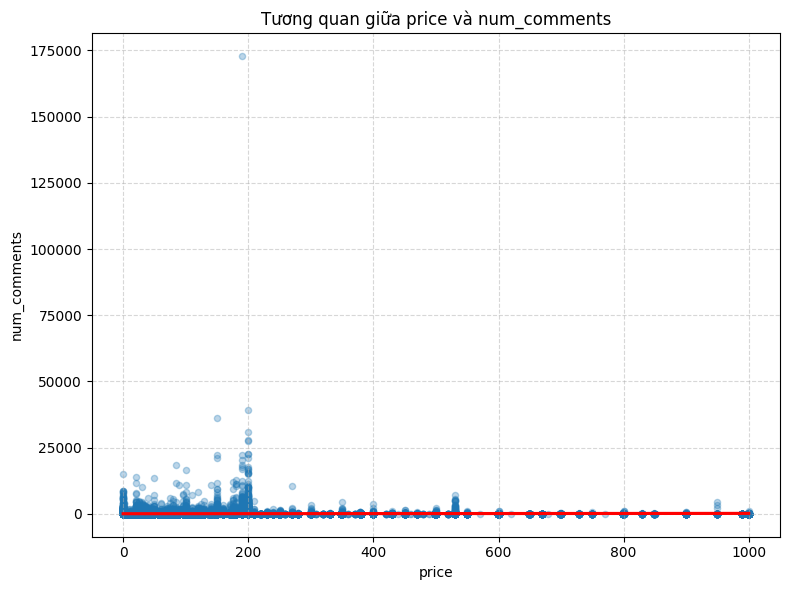

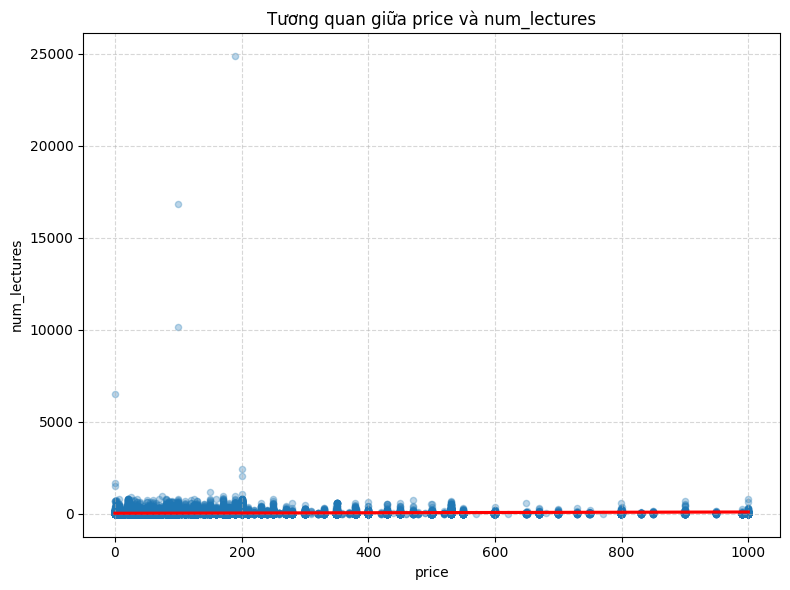

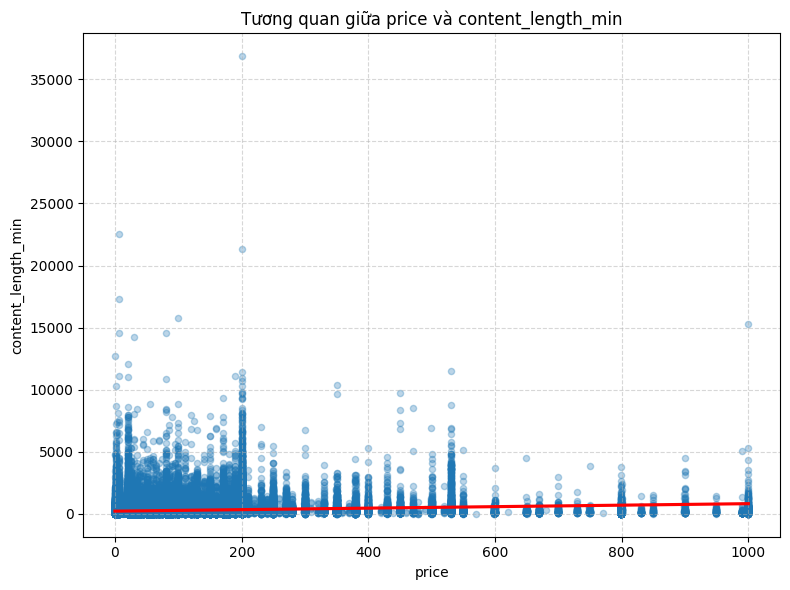

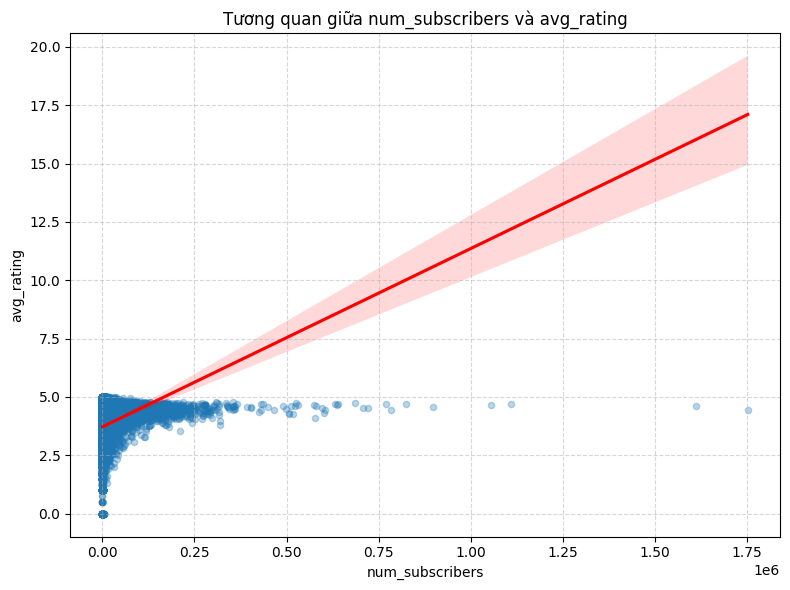

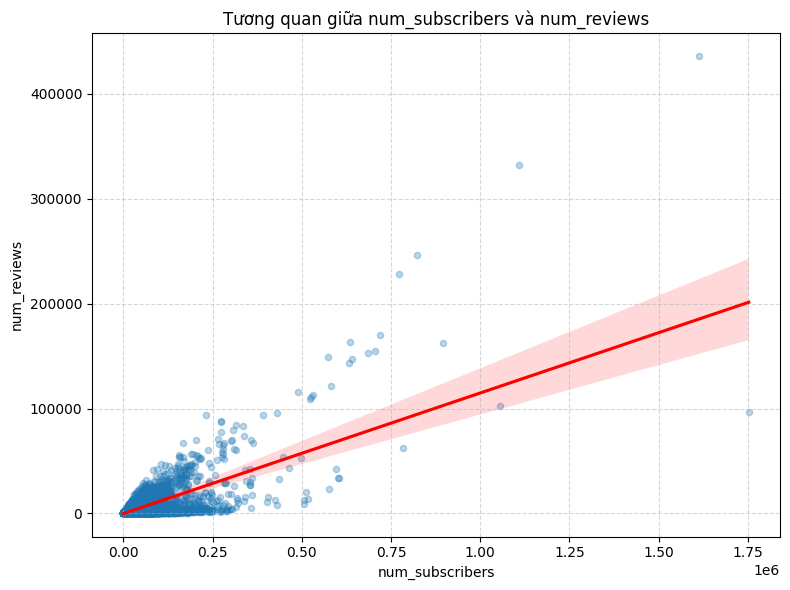

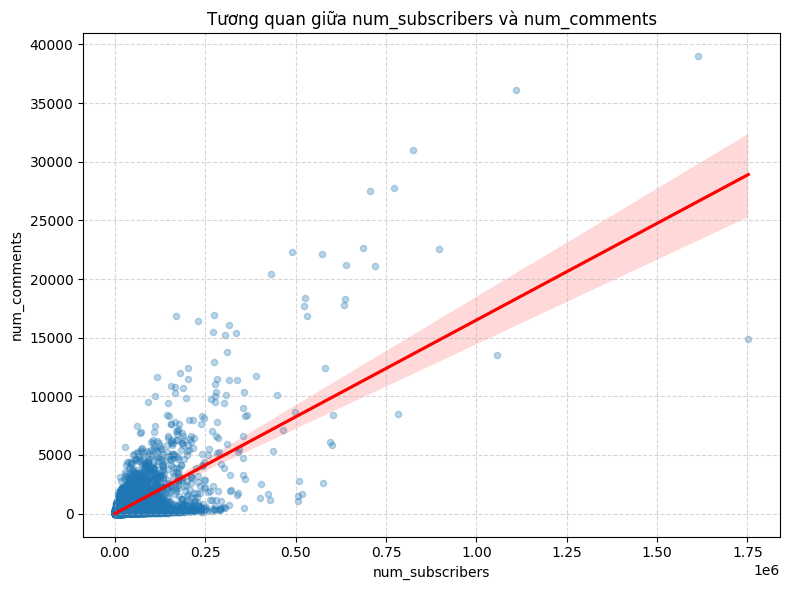

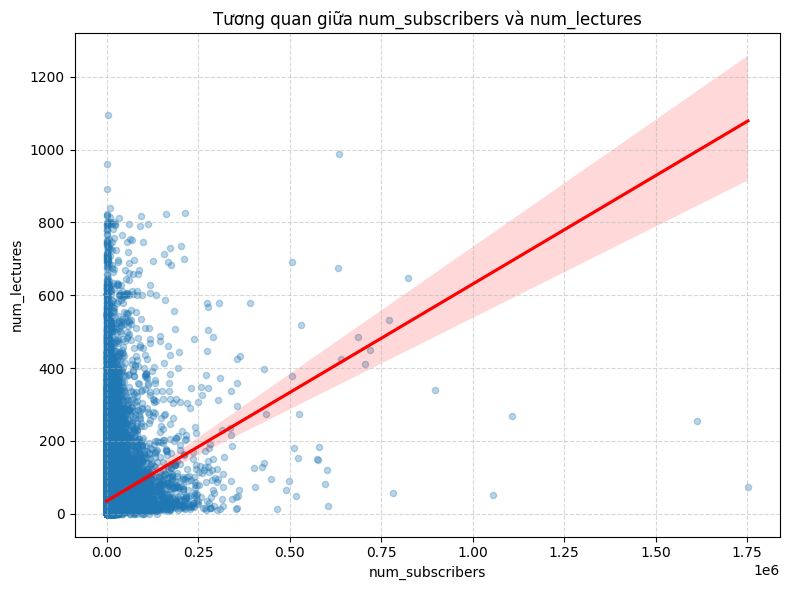

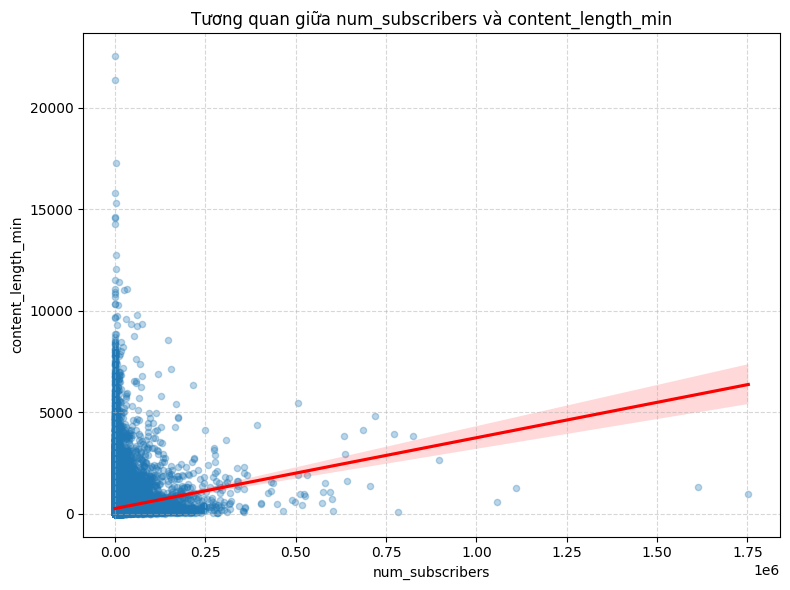

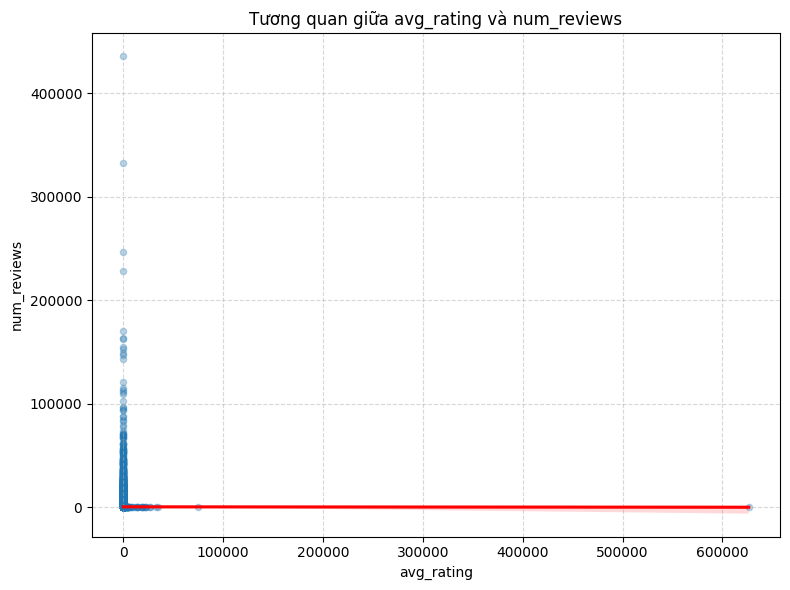

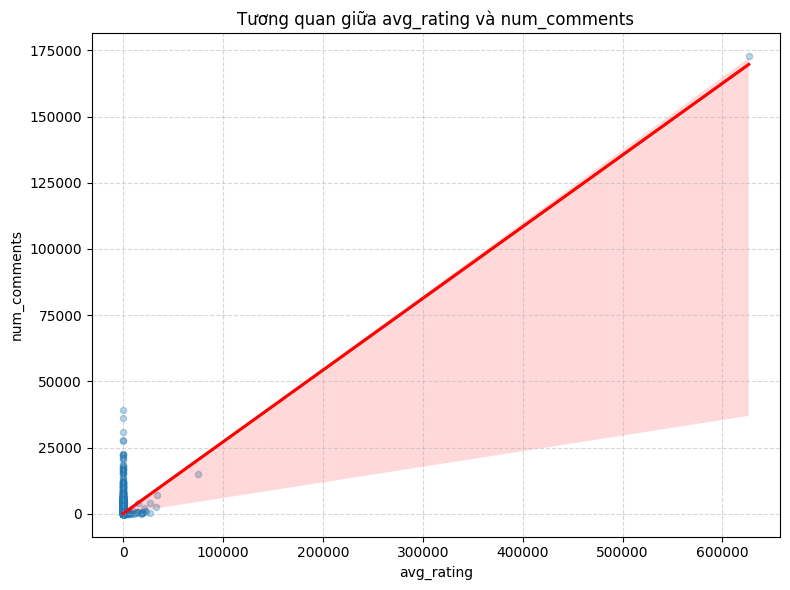

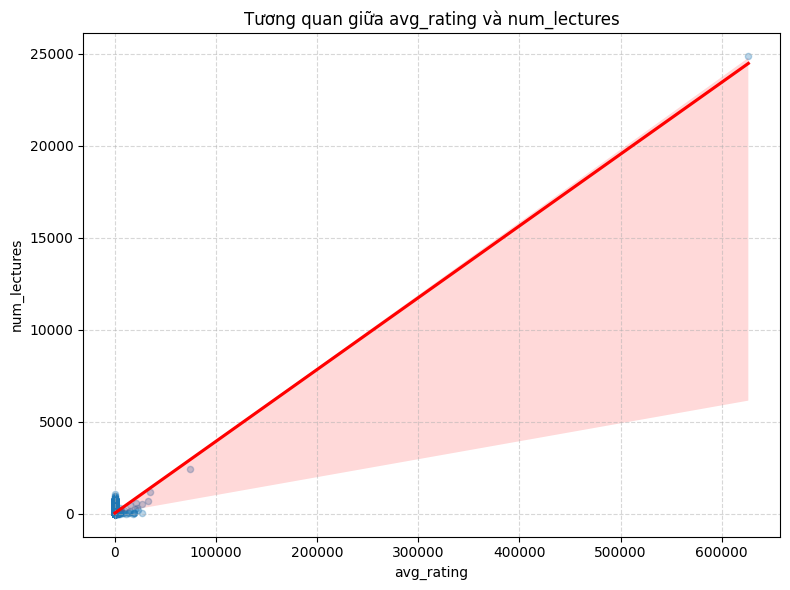

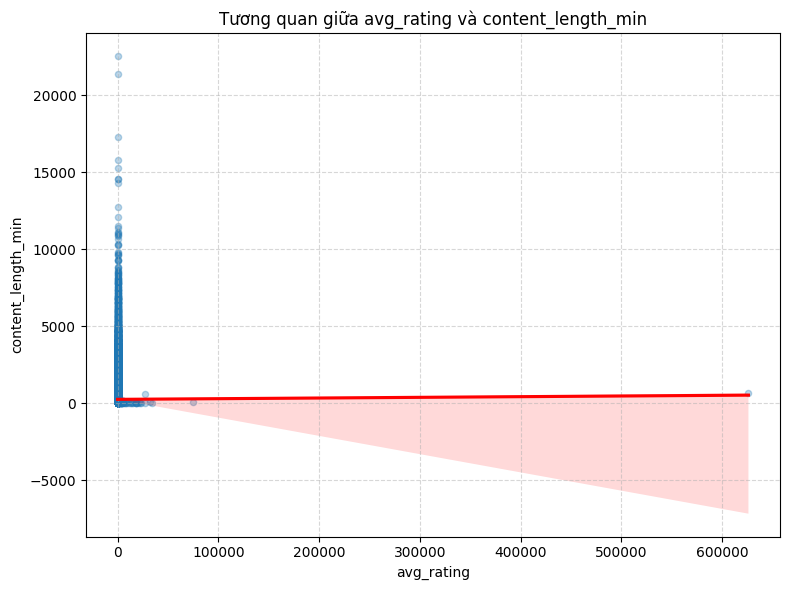

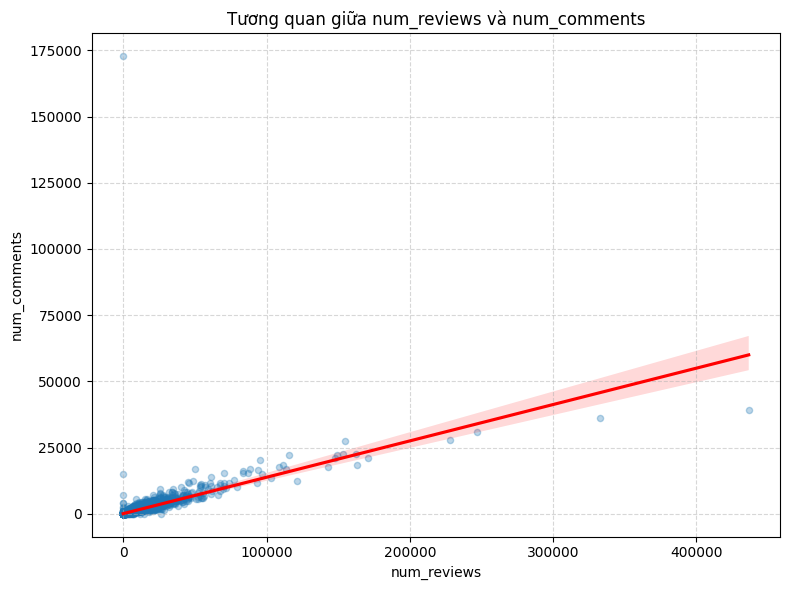

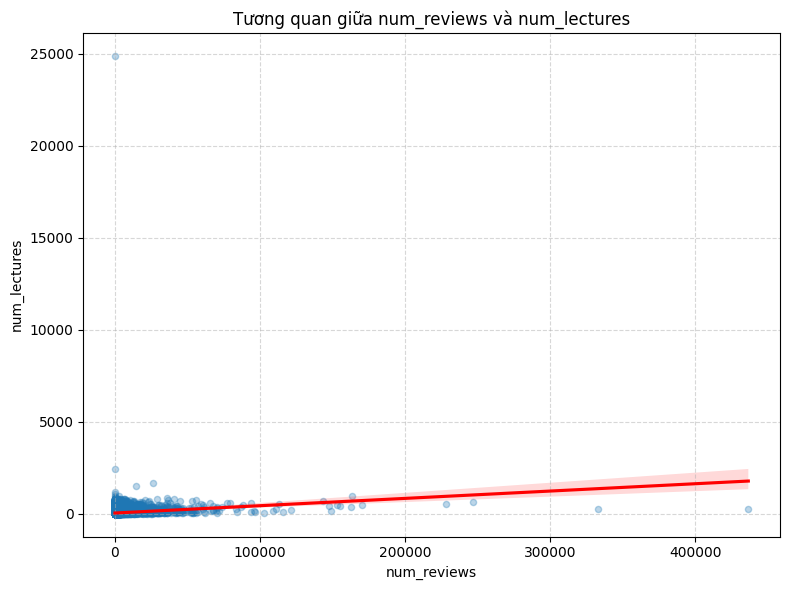

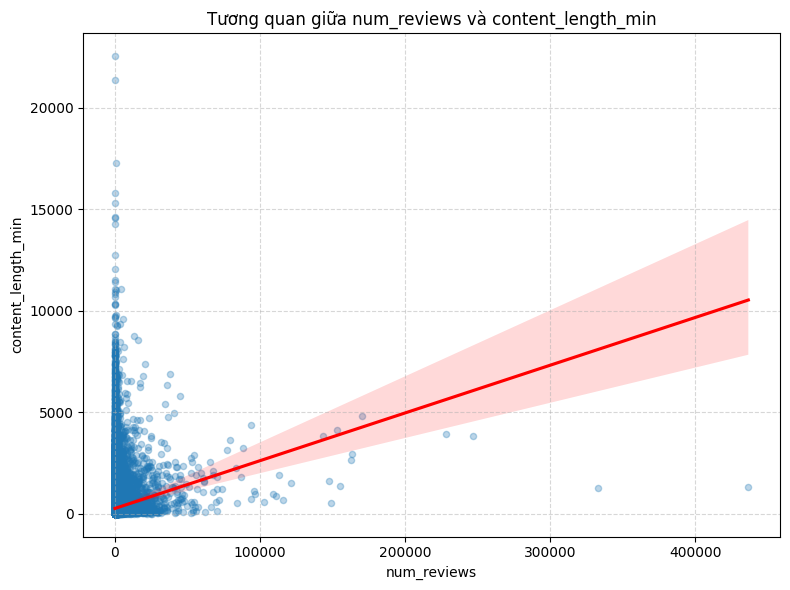

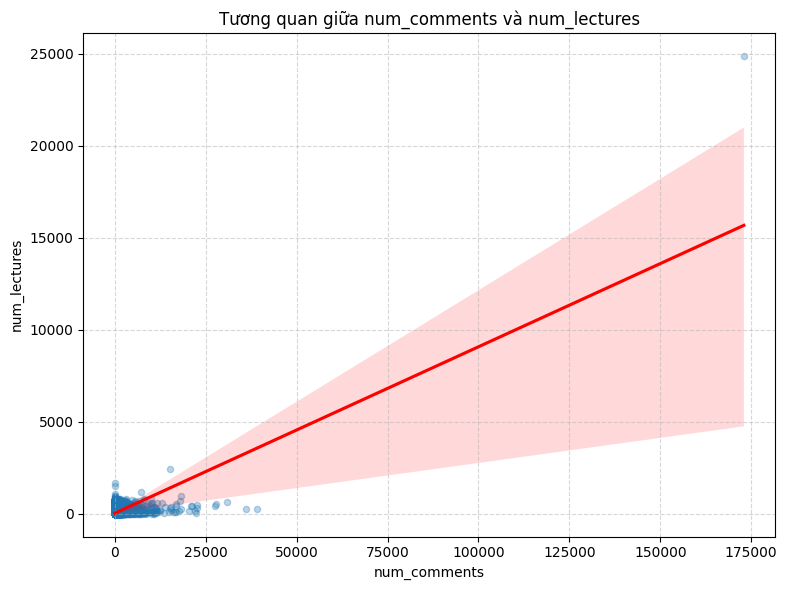

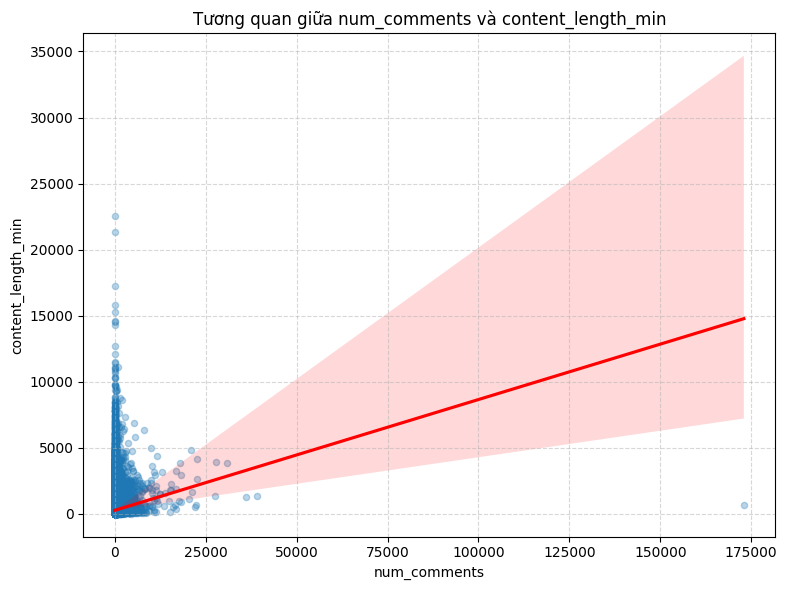

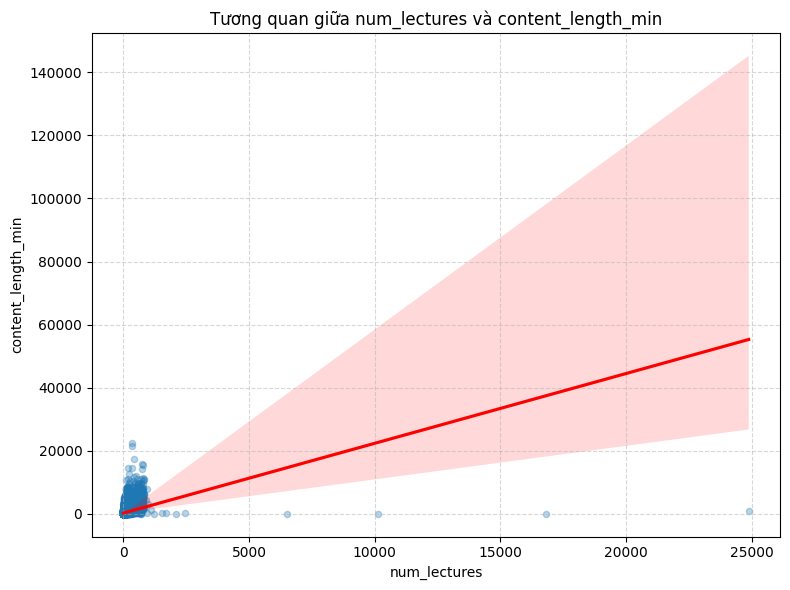

In [23]:
import itertools

def plot_pairwise_scatter_with_reg(df_pd, cols):
    pairs = list(itertools.combinations(cols, 2))  # Lấy tất cả cặp không lặp
    for x_col, y_col in pairs:
        plt.figure(figsize=(8, 6))
        sns.regplot(data=df_pd, x=x_col, y=y_col, scatter_kws={'alpha': 0.3, 's': 20}, line_kws={"color": "red"})
        plt.title(f"Tương quan giữa {x_col} và {y_col}")
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

#khi đã có df_pd từ Spark DataFrame
plot_pairwise_scatter_with_reg(df_pd, numerical_cols)

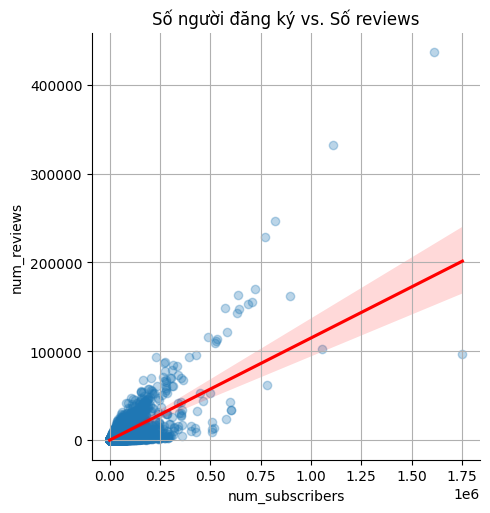

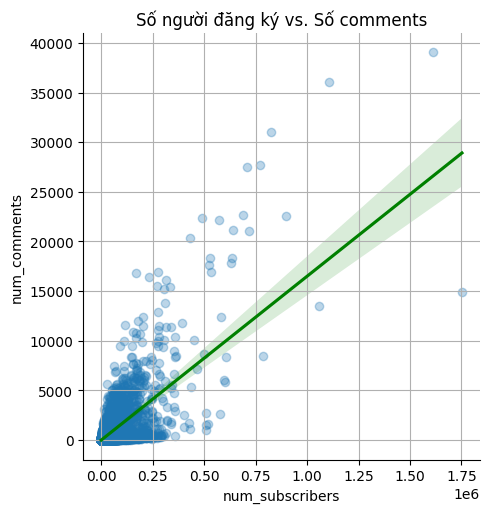

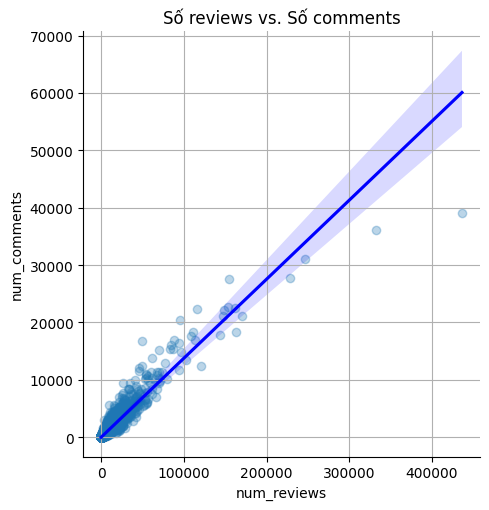

In [29]:
# num_subscribers vs num_reviews
sns.lmplot(data=df_pd, x="num_subscribers", y="num_reviews",
           scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
plt.title("Số người đăng ký vs. Số reviews")
plt.grid(True)
plt.show()

# num_subscribers vs num_comments
sns.lmplot(data=df_pd, x="num_subscribers", y="num_comments",
           scatter_kws={"alpha": 0.3}, line_kws={"color": "green"})
plt.title("Số người đăng ký vs. Số comments")
plt.grid(True)
plt.show()

# num_reviews vs num_comments
sns.lmplot(data=df_pd, x="num_reviews", y="num_comments",
           scatter_kws={"alpha": 0.3}, line_kws={"color": "blue"})
plt.title("Số reviews vs. Số comments")
plt.grid(True)
plt.show()